In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization, Activation
import os
import seaborn as sns
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.applications import ResNet50
from keras.optimizers import Adam
import math
import keras

In [2]:
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
SIZE = 128

# Load the images by defining the function
def load_images(directory_path):
    images = []
    labels = []
    for directory_path in glob.glob(directory_path):  
        label = os.path.basename(directory_path)
        # print(label)
        for img_path in glob.glob(os.path.join(directory_path, "*.*")):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
            img = cv2.resize(img, (SIZE, SIZE))  
            images.append(img)
            labels.append(label)

    images = np.array(images)  
    labels = np.array(labels)  

    return images, labels

### Remove the background of the images

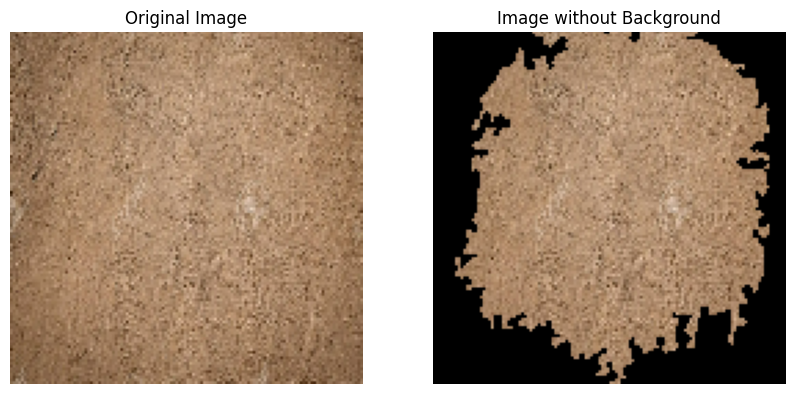

In [20]:
# Here we remove the background of the images to identify and analyze specific objects of interest within an image and to reduce the noise

def remove_background(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reducing Noise of the image
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Finding the contours
    max_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [max_contour], -1, 255, -1)
    result = cv2.bitwise_and(img, img, mask=mask)
    
    return result

# Here Load train images and test images
train_images, train_labels = load_images("dataset/dataset/train/*")
test_images, test_labels = load_images("dataset/dataset/val/*")

# Preprocess images by removing background
train_images_without_bg = [remove_background(img) for img in train_images]
test_images_without_bg = [remove_background(img) for img in test_images]

import random

# Select random indices
num_samples = 1  # Number of random samples to display
random_indices = random.sample(range(len(train_images)), num_samples)

# Display random images with and without background
for idx in random_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(train_images[idx], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Image without Background")
    plt.imshow(cv2.cvtColor(train_images_without_bg[idx], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

### Augmentation

In [5]:
# Here we will apply augmentation to increase the diversity of the images, to prevent from overfitting and increase performance
# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,   # Rotate images by a random angle within the range [-20, 20] degrees
    width_shift_range=0.2,   # Shift images horizontally by a fraction of total width
    height_shift_range=0.2,  # Shift images vertically by a fraction of total height
    shear_range=0.2,   # Shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,   # Randomly zooming inside the image
    horizontal_flip=True,   # Randomly flip inputs horizontally
    vertical_flip=True,   # Randomly flip inputs vertically
    fill_mode='nearest'   # Fill points outside the input boundaries
)

# Number of augmented images per input image
num_augmentations = 5

# Prepare the training data for augmentation
train_images_augmented = []
for img in train_images_without_bg:
    img = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img, batch_size=1)
    train_images_augmented.extend([next(augmented_imgs)[0] for _ in range(num_augmentations)])

# Convert the list of augmented images to numpy array
train_images_augmented = np.array(train_images_augmented)

In [6]:
train_images_augmented.shape

(1220, 128, 128, 3)

In [7]:
len(train_images_without_bg)

244

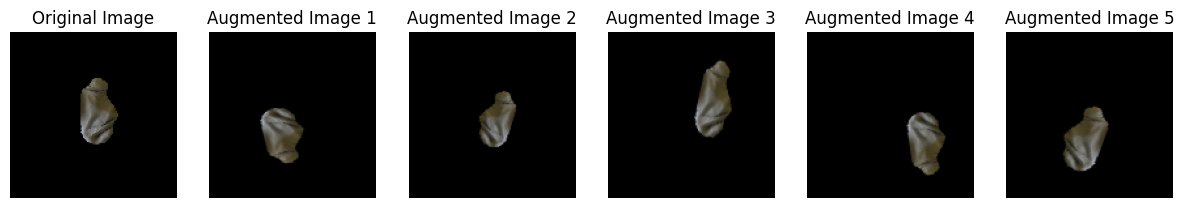

In [23]:
# Here a random original image along with its augmented images will be shown
# Select a random index
random_index = np.random.randint(len(train_images_without_bg))

# Display the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, num_augmentations + 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(train_images_without_bg[random_index], cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the augmented images
for i in range(1, num_augmentations + 1):
    plt.subplot(1, num_augmentations + 1, i + 1)
    plt.title(f"Augmented Image {i}")
    augmented_rgb = cv2.cvtColor(train_images_augmented[random_index * num_augmentations + i - 1], cv2.COLOR_BGR2RGB)
    augmented_rgb = augmented_rgb / 255.0  # Normalize pixel values to [0, 1]
    plt.imshow(augmented_rgb)
    plt.axis('off')

plt.show()

In [9]:
# Concatenate the arrays along the first axis (axis=0), which represents the samples
total_train_images = np.concatenate((train_images_augmented, train_images_without_bg), axis=0)

### Loading image data for training the model

In [10]:
# Here we load all the training images to train all the models
SIZE = 128

train_images = []
train_labels = []
for directory_path in glob.glob("dataset/dataset/train/*"):   # Fetches all image folders in the given path
    label = directory_path.split("\\")[-1]
    # label = os.path.basename(directory_path)
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)   # Iterate each image file and load it
        img = cv2.resize(img, (SIZE, SIZE))   # Resize each image to 128 x 128 pixels
        
        # Append original image
        train_images.append(img)
        train_labels.append(label)

        # # Generate augmented images
        # for _ in range(num_augmentations):
        #     augmented_img = datagen.flow(img.reshape((1,) + img.shape), batch_size=1)
        #     augmented_img = next(augmented_img)[0]
        #     train_images.append(augmented_img)
        #     train_labels.append(label)

train_images = np.array(train_images)   # Convert the lists of images and labels into numpy arrays
train_labels = np.array(train_labels)   # Convert the lists of images and labels into numpy arrays

clay
loam
loamy sand
sand
sandy loam


### Loading image data for validating or testing the model

In [11]:
# Here we load all the test images to test all the models

test_images = []
test_labels = []
for directory_path in glob.glob("dataset/dataset/val/*"):
    fruit_label = directory_path.split("\\")[-1]
    # fruit_label = os.path.basename(directory_path)
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        #print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        test_labels.append(fruit_label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

### Encode labels from text to integers

In [12]:
# Here we will assign each label a specific integer due to classification tasks and loss calculations

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [13]:
num_classes = len(le.classes_)  # It represents number of unique classes
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes)
print(num_classes)
# # Scale the pixel values between 0 and 1
# train_images_scaled = train_images_without_bg / 255.0
# test_images_scaled = test_images_without_bg / 255.0

5


In [14]:
train_labels

array(['clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'loam', 'loam', 'loam', 'loam', 'loam',
       'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam',
       'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam',
      

In [15]:
train_labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [16]:
test_labels

array(['clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'loam',
       'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam',
       'loam', 'loam', 'loam', 'loam', 'loamy sand', 'loamy sand',
       'loamy sand', 'loamy sand', 'loamy sand', 'loamy sand',
       'loamy sand', 'loamy sand', 'loamy sand', 'loamy sand',
       'loamy sand', 'loamy sand', 'loamy sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', '

### Assigning values to the variables

In [17]:
# Here we are assigning variables
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [18]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((244, 128, 128, 3), (244,), (119, 128, 128, 3), (119,))

In [19]:
train_images_augmented.shape

(1220, 128, 128, 3)

In [20]:
x_train

array([[[[130, 139, 167],
         [ 43,  45,  66],
         [137, 143, 168],
         ...,
         [164, 166, 195],
         [123, 128, 156],
         [ 56,  61,  99]],

        [[ 32,  40,  61],
         [115, 122, 142],
         [123, 130, 155],
         ...,
         [117, 128, 155],
         [ 59,  69,  98],
         [158, 163, 189]],

        [[ 84,  93, 121],
         [ 97, 100, 129],
         [ 68,  79, 107],
         ...,
         [111, 122, 149],
         [162, 170, 199],
         [ 82,  84, 104]],

        ...,

        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],

        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],

        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [  1,   1,   1],
        

In [21]:
test_labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4])

In [22]:
# Here we are scaling pixel values between 0 and 1 as we know that neural networks tend to perform better when working with normalized data
x_train, x_test = x_train / 255.0, x_test / 255.0

# One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## ResNet50 Model

In [23]:
from keras.applications import ResNet50V2

In [24]:
# Here Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the convolutional layers to prevent updating their weights during training
for layer in base_model.layers:
    layer.trainable = False

# Adding custom dense layers for classification on top of ResNet50
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)

In [25]:
# Here we determine the number of classes
num_classes = len(le.classes_)
output = Dense(num_classes, activation='softmax')(x)  # Assuming num_classes is the number of classes in your dataset

In [26]:
# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Training the model
history = model.fit(x_train, y_train_one_hot, epochs=20, batch_size=64, validation_data=(x_test, y_test_one_hot))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print('Test accuracy:', test_acc)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,977,861 (121.99 MB)

 Trainable params: 8,390,149 (32.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.2210 - loss: 2.8293 - val_accuracy: 0.1261 - val_loss: 2.3741
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3304 - loss: 2.0847 - val_accuracy: 0.1681 - val_loss: 1.7413
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2405 - loss: 1.5912 - val_accuracy: 0.5798 - val_loss: 1.4127
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3973 - loss: 1.5201 - val_accuracy: 0.4286 - val_loss: 1.4907
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4577 - loss: 1.4213 - val_accuracy: 0.3950 - val_loss: 1.5141
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4815 - loss: 1.3388 - val_accuracy: 0.5210 - val_loss: 1.2999
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4915 - loss: 1.2487 - val_accuracy: 0.5630 - val_loss: 1.2877
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5022 - loss: 1.2735 - val_accuracy: 0.5378 - val_loss: 1.3129
Epoch 9/

## ResNet50v2 Model

In [27]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [28]:
# First define ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Add custom layers on top of ResNet50V2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

from keras.applications.resnet_v2 import preprocess_input

# Here we preprocess the images for ResNet50V2
train_images_preprocessed = preprocess_input(train_images)
test_images_preprocessed = preprocess_input(test_images)


# Train the model
model.fit(datagen.flow(train_images_preprocessed, train_labels_one_hot, batch_size=32),
          steps_per_epoch=int(len(train_images_preprocessed) / 32), epochs=10)

# Display model summary
model.summary()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_preprocessed, test_labels_one_hot)
print("Test Accuracy:", test_acc)


Epoch 1/10


C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 929ms/step - accuracy: 0.3125 - loss: 2.3823
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6500 - loss: 0.4496 
Epoch 3/10


C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 887ms/step - accuracy: 0.6284 - loss: 1.5130
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6500 - loss: 0.6259  
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 842ms/step - accuracy: 0.7520 - loss: 0.7078
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.4124  
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 769ms/step - accuracy: 0.7301 - loss: 0.7348
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.2078  
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - accuracy: 0.8678 - loss: 0.5935
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.2875  


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 32, 32, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 32, 32, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 34, 34, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 29,874,705 (113.96 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 4,206,604 (16.05 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 738ms/step - accuracy: 0.7955 - loss: 0.6239
Test Accuracy: 0.8403361439704895


## VGG16 Model

In [29]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D  # Add this import statement

In [30]:
# Here we convert images to array and scale pixel values between 0 and 1
train_images_without_bg = np.array(train_images_without_bg) / 255.0
test_images_without_bg = np.array(test_images_without_bg) / 255.0

In [31]:
num_classes = len(le.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images_without_bg, train_labels_one_hot,
                    batch_size=32,
                    epochs=10,
                    validation_data=(test_images_without_bg, test_labels_one_hot))

# Display model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(test_images_without_bg, test_labels_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.2921 - loss: 1.5799 - val_accuracy: 0.1345 - val_loss: 1.5308
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4554 - loss: 1.2291 - val_accuracy: 0.6639 - val_loss: 1.1720
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5856 - loss: 1.1314 - val_accuracy: 0.4622 - val_loss: 1.1846
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5668 - loss: 1.0959 - val_accuracy: 0.7227 - val_loss: 0.9881
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6527 - loss: 0.9513 - val_accuracy: 0.6975 - val_loss: 0.9281
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6594 - loss: 0.9476 - val_accuracy: 0.5798 - val_loss: 0.9946
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6909 - loss: 0.8684 - val_accuracy: 0.7143 - val_loss: 0.8416
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6948 - loss: 0.8400 - val_accuracy: 0.6807 - val_loss: 0.8534
Epoch 9/

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 15,510,353 (59.17 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 530,444 (2.02 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7221 - loss: 0.7612
Test Loss: 0.7150064706802368
Test Accuracy: 0.7478991746902466


## VGG19 Model

In [32]:
from keras.applications import VGG19  # Import VGG19

In [33]:
# Define VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Assuming num_classes is defined elsewhere

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images_without_bg, y_train_one_hot, epochs=10, batch_size=32, validation_data=(test_images_without_bg, y_test_one_hot))
# history = model.fit(total_train_images, y_train_one_hot, epochs=10, batch_size=32, validation_data=(test_images_without_bg, y_test_one_hot))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_without_bg, y_test_one_hot)
print('Test accuracy:', test_acc)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.3550 - loss: 1.6374 - val_accuracy: 0.5714 - val_loss: 1.2380
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.3895 - loss: 1.3410 - val_accuracy: 0.2101 - val_loss: 1.5105
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5154 - loss: 1.0893 - val_accuracy: 0.3950 - val_loss: 1.1532
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5862 - loss: 0.9708 - val_accuracy: 0.7731 - val_loss: 0.7897
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.7308 - loss: 0.7390 - val_accuracy: 0.5714 - val_loss: 0.8681
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.7302 - loss: 0.6595 - val_accuracy: 0.7983 - val_loss: 0.6264
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8597 - loss: 0.4598 - val_accuracy: 0.8824 - val_loss: 0.4411
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9209 - loss: 0.3584 - val_accuracy: 0.9160 - val_loss: 0.2995
Epoch 9/

## ResNet50v2 + Morphology Filter

In [34]:
from keras.applications import ResNet50V2
from keras.layers import Input
from keras.models import Model
from scipy import ndimage
from skimage.morphology import binary_opening, disk

In [35]:
# pip install scikit-image

In [36]:
# Here we will apply Morphology Filter to remove noise
def preprocess_image(img):
    kernel = disk(3)  # Adjust the disk size according to our preference
    img_processed = binary_opening(img, kernel)
    return img_processed

In [37]:
# Load pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define new model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_data=(test_images, test_labels_one_hot))
# history = model.fit(total_train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_data=(test_images, test_labels_one_hot))

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3764 - loss: 579.5608 - val_accuracy: 0.3109 - val_loss: 327.3556
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3894 - loss: 345.0472 - val_accuracy: 0.5546 - val_loss: 179.4082
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4657 - loss: 275.8337 - val_accuracy: 0.3866 - val_loss: 249.4428
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5079 - loss: 193.4204 - val_accuracy: 0.6975 - val_loss: 74.3118
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5975 - loss: 90.4267 - val_accuracy: 0.6218 - val_loss: 45.0428
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7243 - loss: 39.5034 - val_accuracy: 0.7059 - val_loss: 42.4013
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7495 - loss: 39.5804 - val_accuracy: 0.8319 - val_loss: 48.7876
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8428 - loss: 21.0522 - val_accuracy: 0.7647 - val

In [38]:
from skimage.feature import local_binary_pattern  # Corrected import

In [39]:
import scipy.stats as st

## Gabor Feature Extractor CNN Model

In [40]:
SIZE = 128  # Here we will assign value of size to 128

# First we define Gabor filters
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        for sigma in (1, 3):
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    return filters

In [41]:
# Apply Gabor filters to images
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [42]:
# Here we initialize Gabor filters
filters = build_filters()

# Apply Gabor filters to train and test images
train_images_gabor = [process(img, filters) for img in train_images_without_bg]
# train_images_gabor = [process(img, filters) for img in total_train_images]
test_images_gabor = [process(img, filters) for img in test_images_without_bg]

# Convert to numpy arrays
train_images_gabor = np.array(train_images_gabor)
test_images_gabor = np.array(test_images_gabor)

In [43]:
# Convert to numpy arrays
train_images_gabor = np.array(train_images_gabor)
test_images_gabor = np.array(test_images_gabor)

# Define model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [44]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Here we fit and transform labels for both train and test data
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert to one-hot encoding
num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes)


In [46]:
# Train the model
model.fit(train_images_gabor, train_labels_encoded, epochs=20, validation_data=(test_images_gabor, test_labels_encoded))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_gabor, test_labels_encoded)
print("Test accuracy:", test_acc)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.2623 - loss: 2.6543 - val_accuracy: 0.1681 - val_loss: 1.8069
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4351 - loss: 1.3717 - val_accuracy: 0.4286 - val_loss: 1.0817
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.5288 - loss: 1.0458 - val_accuracy: 0.6555 - val_loss: 0.8426
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.7131 - loss: 0.7635 - val_accuracy: 0.8571 - val_loss: 0.5246
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.8061 - loss: 0.5314 - val_accuracy: 0.9664 - val_loss: 0.3433
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.9043 - loss: 0.3370 - val_accuracy: 0.9664 - val_loss: 0.1855
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.8992 - loss: 0.2639 - val_accuracy: 0.9328 - val_loss: 0.1583
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.9226 - loss: 0.2192 - val_accuracy: 0.9748 - val_loss:

## Integrated CNN-RFC Classifier

In [47]:
def build_gabor_kernel(theta, Lambda, psi, sigma, gamma):
    """
    Build a Gabor kernel with the specified parameters.

    :param theta: Orientation of the Gabor filter.
    :param Lambda: Wavelength of the sinusoidal factor.
    :param psi: Phase offset of the sinusoidal factor.
    :param sigma: Standard deviation of the Gaussian envelope.
    :param gamma: Spatial aspect ratio.
    :return: Gabor kernel.
    """
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * math.cos(theta)), abs(nstds * sigma_y * math.sin(theta)))
    xmax = math.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * math.sin(theta)), abs(nstds * sigma_y * math.cos(theta)))
    ymax = math.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * math.cos(theta) + y * math.sin(theta)
    y_theta = -x * math.sin(theta) + y * math.cos(theta)

    # Gabor function
    gb = np.exp(-0.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(
        2 * np.pi / Lambda * x_theta + psi)

    # Rescale to [0, 1]
    gb -= np.min(gb)
    gb /= np.max(gb)

    # Reshape for Keras
    gb = np.reshape(gb, (ymax - ymin + 1, xmax - xmin + 1))
    gb = cv2.resize(gb, (3, 3))

    return gb

In [48]:
class GaborConv2D(Conv2D):
    """
    2D Gabor Convolutional layer.
    """

    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', data_format=None,
                 dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, theta=8, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1, **kwargs):


    #def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
     #            dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='he_normal',
     #            bias_initializer='he_normal', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2',
     #            kernel_constraint=None, bias_constraint=None, theta=8, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1, **kwargs):


        super(GaborConv2D, self).__init__(
            filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, data_format=data_format,
            dilation_rate=dilation_rate, activation=activation, use_bias=use_bias, kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint, bias_constraint=bias_constraint,
            **kwargs)

        self.theta = theta
        self.Lambda = Lambda
        self.psi = psi
        self.sigma = sigma
        self.gamma = gamma
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        """
        Build the Gabor kernel.

        :param input_shape: Shape of the input tensor.
        """
        input_dim = input_shape
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        input_dim = input_shape[channel_axis]
        #kernel_shape = self.kernel_size + (input_dim, self.filters)
        def build(self, input_shape):
            kernel_shape = self.kernel_size + (input_shape[-1], self.filters)

    # Create a trainable weight variable for this layer.
            self.kernel = self.add_weight(name='kernel',
                                  shape=kernel_shape,
                                  initializer='he_normal',
                                  #initializer= 'glorot_uniform'
                                  trainable=True)

            super(GaborConv2D, self).build(input_shape)


    def call(self, inputs):

        if self.data_format == 'channels_first':
            outputs = K.conv2d(inputs, self.kernel, strides=self.strides,
                               padding=self.padding, data_format=self.data_format,
                               dilation_rate=self.dilation_rate)
        else:
            kernel = K.permute_dimensions(self.kernel, (0, 1, 3, 2))
            outputs = K.conv2d(inputs, kernel, strides=self.strides,
                               padding=self.padding, data_format=self.data_format,
                               dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias, data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    # new layer added
    ''' def get_config(self):
        config = super(GaborConv2D, self).get_config()
        config.update({"units": self.units})
        return config'''

In [49]:
theta = 8.0
Lambda = np.pi/4
psi = 10.0
sigma = 0.5
gamma = 0.1

In [50]:
import tensorflow as tf

In [51]:
class GaborConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, theta, Lambda, psi, sigma, gamma, **kwargs):
        super(GaborConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.theta = theta
        self.Lambda = Lambda
        self.psi = psi
        self.sigma = sigma
        self.gamma = gamma

    def build(self, input_shape):


        kernel_shape = list(self.kernel_size) + [input_shape[-1], self.filters]
        #print('its running kernel shape ',kernel_shape)
        kernel = np.zeros(kernel_shape)
        for i in range(self.filters):
            kernel[:, :, :, i] = build_gabor_kernel(theta=self.theta, Lambda=self.Lambda, psi=self.psi,
                                                    sigma=self.sigma, gamma=self.gamma)
        self.kernel = tf.Variable(kernel, trainable=True, name='kernel')
        # self.kernel = K.cast(self.kernel, dtype='float32')
        self.kernel = tf.cast(self.kernel, dtype=tf.float32)



    def call(self, inputs):
        outputs = tf.nn.conv2d(inputs, self.kernel, strides=(1, 1), padding="SAME")
        return outputs


    # new layer added get config only
    '''def get_config(self):
        config = super(GaborConv2D, self).get_config()
        config.update({"units": self.units})
        return config'''

In [52]:
from tensorflow.keras.layers import Input, Activation, MaxPooling2D, Flatten, Dense,Conv2D,BatchNormalization
from tensorflow.keras.models import Model
import keras

In [53]:
import math

In [54]:
from keras import backend as K
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [55]:
SIZE = 128
# Define input shape
input_shape = (SIZE, SIZE, 3)

# Define model architecture
inputs = Input(shape=input_shape)
x = GaborConv2D(filters=2, kernel_size=(3, 3), theta=8.0, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1)(inputs)

x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(2, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)


x = MaxPooling2D()(x)
x = Conv2D(4, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)


x = Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = MaxPooling2D()(x)

x = Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
# x = MaxPooling2D()(x)


x = Flatten()(x)

x = Dense(64, activation = 'relu',kernel_initializer='he_normal')(x)
out  = Dense(5, activation = 'softmax',kernel_initializer='he_normal')(x)

GCN_model = Model(inputs=inputs, outputs = out)

In [56]:
GCN_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gabor_conv2d (GaborConv2D)           │ (None, 128, 128, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 2)           │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 2)           │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 4)           │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 4)           │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 8)           │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 16)          │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 16)            │           4,1

 Total params: 81,595 (318.73 KB)

 Trainable params: 81,343 (317.75 KB)

 Non-trainable params: 252 (1008.00 B)

In [57]:
GCN_model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [58]:
history2 = GCN_model.fit(x_train, y_train_one_hot,batch_size=8, epochs=30, validation_data = (x_test, y_test_one_hot))

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3181 - loss: 1.8227 - val_accuracy: 0.2521 - val_loss: 1.4798
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6207 - loss: 0.9046 - val_accuracy: 0.3782 - val_loss: 1.4730
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7231 - loss: 0.8026 - val_accuracy: 0.5630 - val_loss: 1.3514
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7456 - loss: 0.6450 - val_accuracy: 0.2101 - val_loss: 1.5552
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8463 - loss: 0.4963 - val_accuracy: 0.4370 - val_loss: 1.3379
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8519 - loss: 0.3603 - val_accuracy: 0.3193 - val_loss: 1.3898
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8800 - loss: 0.3370 - val_accuracy: 0.3277 - val_loss: 1.4709
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8997 - loss: 0.3204 - val_accuracy: 0.3445 - v

In [59]:
feature_extractor_gcn = Model(inputs=GCN_model.input, outputs=GCN_model.layers[-2].output)

# Use the feature extractor to get features from your data
features_train = feature_extractor_gcn.predict(x_train)
# print(features_train.shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [60]:
features_test = feature_extractor_gcn.predict(x_test)
# features_test.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [62]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

rf_classifier.fit(features_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [63]:
prediction_RF = rf_classifier.predict(features_test)
prediction_RF = le.inverse_transform(prediction_RF)

print("Test Labels:", test_labels.shape)
print(test_labels)

print("Prediction", prediction_RF.shape)
print(prediction_RF)

Test Labels: (119,)
['clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay'
 'clay' 'clay' 'clay' 'clay' 'clay' 'loam' 'loam' 'loam' 'loam' 'loam'
 'loam' 'loam' 'loam' 'loam' 'loam' 'loam' 'loam' 'loam' 'loamy sand'
 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand'
 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand'
 'loamy sand' 'loamy sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam'
 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam'
 'sandy l

In [64]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.9915966386554622


In [65]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, prediction_RF))

              precision    recall  f1-score   support

        clay       1.00      1.00      1.00        15
        loam       1.00      1.00      1.00        13
  loamy sand       1.00      0.92      0.96        13
        sand       0.99      1.00      0.99        66
  sandy loam       1.00      1.00      1.00        12

    accuracy                           0.99       119
   macro avg       1.00      0.98      0.99       119
weighted avg       0.99      0.99      0.99       119



<Axes: >

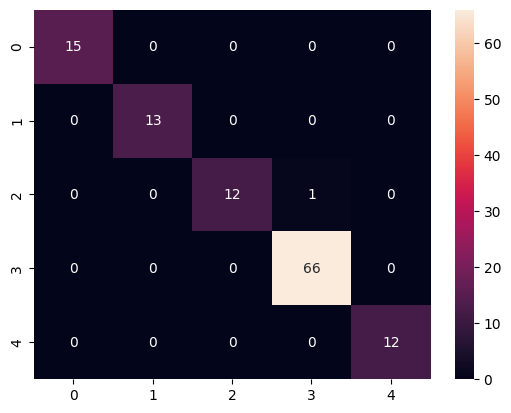

In [66]:
from sklearn.metrics import confusion_matrix

#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF)
sns.heatmap(cm, annot=True)

## BagNet

In [67]:
def getPatch(image, patch_h, patch_w, index_h, index_w):
    height = image.shape[1]
    width = image.shape[2]
    return image[:, (index_h*patch_h):((index_h+1)*patch_h), 
                 (index_w*patch_w):((index_w+1)*patch_w), :]

In [68]:
keras.models.Sequential()

<Sequential name=sequential_2, built=False>

In [69]:
def cnnBlock(input):
    from keras import layers

    x = GaborConv2D(filters=2, kernel_size=(3, 3), theta=8.0, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1)(input)

    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(2, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)


    x = MaxPooling2D()(x)
    x = Conv2D(4, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)


    x = Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    return x

In [70]:
# BAGNET BLOCK
def bagnetBlock(input, patchHeight, patchWidth, h, w):
    import keras
    from keras import layers
    
    patch = getPatch(input, patchHeight, patchWidth, h, w)
    cnn = cnnBlock(patch)
    flat = layers.Flatten()(cnn)
    dense = layers.Dense(5, activation='softmax')(flat)
    return dense

In [71]:
# BUILDS MODEL
def buildModel(imgHeight, imgWidth, patchHeight, patchWidth):
    import keras
    from keras import initializers
    from keras import layers
    from keras import models

    if( imgHeight % patchHeight != 0 ):
        print('Wrong ratio between image height and patch height!')
        return None
    if( imgWidth % patchWidth != 0 ):
        print('Wrong ratio between image width and patch width!')
        return None

    nRows = int(imgHeight / patchHeight)
    nCols = int(imgWidth / patchWidth)

    input = layers.Input(shape=(imgHeight, imgWidth, 3))
    heatmaps = []
    for h in range(nRows):
        for w in range(nCols):
            heatmaps.append( bagnetBlock(input, patchHeight, patchWidth, h, w) )

    classAvgs = layers.Average()(heatmaps)
    softmax = keras.activations.softmax(classAvgs, axis=-1)

    model = models.Model( inputs=input, outputs=softmax )

    return model

In [72]:
# Images size
IM_HEIGHT = 128
IM_WIDTH = 128
PATCH_HEIGHT = 16
PATCH_WIDTH = 16

BATCH_SIZE = 128

In [73]:
# Builds Model
# model = buildModel(IM_HEIGHT, IM_WIDTH, PATCH_HEIGHT, PATCH_WIDTH)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,178,897 (84.61 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,785,932 (56.40 MB)

In [74]:
from keras.utils import to_categorical

# Convert target labels to one-hot encoding
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=BATCH_SIZE, epochs=20, validation_data=(x_test, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3446 - loss: 5.7453 - val_accuracy: 0.2941 - val_loss: 3.4042
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4290 - loss: 2.2154 - val_accuracy: 0.2605 - val_loss: 2.3319
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3147 - loss: 1.9997 - val_accuracy: 0.5378 - val_loss: 1.5719
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4823 - loss: 1.5584 - val_accuracy: 0.6303 - val_loss: 1.2376
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5509 - loss: 1.2002 - val_accuracy: 0.6134 - val_loss: 1.0856
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5375 - loss: 1.1072 - val_accuracy: 0.5882 - val_loss: 1.0219
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5245 - loss: 1.0659 - val_accuracy: 0.6218 - val_loss: 1.0033
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5859 - loss: 0.9789 - val_accuracy: 0.6555 - val_loss: 0.9402
Epoch 9/20
2/2 ━

In [310]:
model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


array([[9.95435655e-01, 2.73556088e-05, 3.17765458e-09, 2.47250975e-09,
        4.53693746e-03],
       [5.08734882e-01, 3.54713923e-03, 2.01688156e-01, 1.66152135e-01,
        1.19877644e-01],
       [8.24506283e-01, 3.03443731e-03, 9.00862738e-03, 7.41648022e-03,
        1.56034097e-01],
       [8.01418126e-01, 5.63025475e-03, 7.36183283e-05, 2.60775050e-05,
        1.92851871e-01],
       [9.00277913e-01, 1.72725623e-03, 1.88159029e-04, 3.90243003e-05,
        9.77676734e-02],
       [5.11090219e-01, 1.97520554e-02, 6.20530592e-03, 1.04622943e-02,
        4.52490091e-01],
       [7.60401666e-01, 4.24335711e-02, 4.16804804e-03, 2.17794324e-03,
        1.90818787e-01],
       [7.78138220e-01, 3.72481160e-02, 2.49740260e-04, 1.81548909e-04,
        1.84182405e-01],
       [9.59230959e-01, 9.38223768e-03, 1.11387436e-07, 1.93675803e-07,
        3.13864686e-02],
       [7.28444874e-01, 8.31134990e-03, 8.33445403e-04, 5.17141423e-04,
        2.61893153e-01],
       [9.99965429e-01, 9.7543

## Testing any random image

In [311]:
import cv2
import numpy as np
from tensorflow.keras.models import Model

def load_and_preprocess_new_images(image_path):
    SIZE = 128  # First assume the same image size used for training

    try:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        if img is None:
            raise FileNotFoundError(f"Failed to read image at path: {image_path}")

        img = cv2.resize(img, (SIZE, SIZE))
        img = np.array(img)
        return img

    except Exception as e:
        print(f"Error loading and preprocessing image: {e}")
        return None

# Here we insert the path of the image we want to test
test_image_path = "dataset/dataset/test/Sample1.jpg"

# Load and preprocess the test image
test_image = load_and_preprocess_new_images(test_image_path)

if test_image is not None:
    test_image = test_image.reshape((1,) + test_image.shape)
    feature_extractor_gcn = Model(inputs=GCN_model.input, outputs=GCN_model.layers[-2].output)
    features_test = feature_extractor_gcn.predict(test_image)

    # Use the trained Random Forest classifier to predict the class label
    prediction_RF = rf_classifier.predict(features_test)
    predicted_class = le.inverse_transform(prediction_RF)[0]

    # Print the predicted class
    print(f"Predicted class for {test_image_path}: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Predicted class for dataset/dataset/test/Sample1.jpg: sand


## Testing all images

In [320]:
import os

def load_and_preprocess_new_images(image_path):
  SIZE = 128  # Here we assume the same image size used for training
  img = cv2.imread(image_path, cv2.IMREAD_COLOR)

  # Resize the image
  img = cv2.resize(img, (SIZE, SIZE))
  img = np.array(img)
  return img

# Here we insert the path of the image we want to test
test_image_folder = "dataset/dataset/test/"

# Get all image paths in the folder
image_paths = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if os.path.isfile(os.path.join(test_image_folder, f))]

preprocessed_images = []

# Loop through each image path
for image_path in image_paths:
  # Load and preprocess the image
  preprocessed_image = load_and_preprocess_new_images(image_path)
  preprocessed_images.append(preprocessed_image)

# Here we process and predict for each preprocessed image
for i, image in enumerate(preprocessed_images):
  # Reshape the image
  image = image.reshape((1,) + image.shape)

  # Here use the trained feature extractor to get features
  features_test = feature_extractor_gcn.predict(image)

  # Then use the trained Random Forest classifier to predict the class label
  prediction_RF = rf_classifier.predict(features_test)

  # Convert the predicted label back to the original class name
  predicted_class = le.inverse_transform(prediction_RF)[0]

  # Print the predicted class for each image
  print(f"Predicted class for {image_paths[i]}: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class for dataset/dataset/test/Loam1.png: clay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class for dataset/dataset/test/Loam2.png: clay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class for dataset/dataset/test/Red Soil.JPG: sand
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class for dataset/dataset/test/Sample1.jpg: sand
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class for dataset/dataset/test/Sample2.jpg: clay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class for dataset/dataset/test/Sample3.jpg: sand
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class for dataset/dataset/test/Sample4.jpg: clay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class for dataset/dataset/test/Sample5(Clay).jpg: clay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class for dataset/dataset/test/SampleLoamySand1.png: clay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class for dataset/dataset/test/SampleLoamySand2.png: sand
1/1 ━━━━━